In [15]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2
# https://jeriwieringa.com/projects/dissertation/
# https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

# http://journalofdigitalhumanities.org/2-1/words-alone-by-benjamin-m-schmidt/
# https://mimno.infosci.cornell.edu/topics.html
# https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/

# Packages

import os
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt
import re
from itertools import compress
from itertools import chain
import ast
import spacy
import nltk
import gensim

# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.test.utils import get_tmpfile, common_texts
from gensim.corpora import MalletCorpus

nlp = spacy.load("da_core_news_sm", disable=['parser', 'ner'])

mallet_path = os.path.join('C:\\', 'mallet', 'mallet-2.0.8', 'bin', 'mallet.bat') # update this path

data_path = os.path.join('D:/', 'data', 'horesta')
out_path = os.path.join('..', 'output')

In [2]:
# Loading data
path = os.path.join(data_path, 'horesta_posts_2021-03-25.json')

with open(path, 'r') as file:
    data = json.load(file)
    
len(data)

1351

In [3]:
# Tokenizer

def tokenizer_spacy(text, stop_words=list(nlp.Defaults.stop_words), tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       
    text = text.replace('\n', ' ')
    numbers_re = r".*\d.*"
    punct_regex = r"[^\w\s]"
    
    doc = nlp(text)
        
    pos_tags = tags # Keeps proper nouns, adjectives and nouns
    
    exceptions = ['covid', 'corona']
    
    tokens = []
      
    for word in doc:
        if ((word.pos_ in pos_tags) or (any([exception in word.text for exception in exceptions]))) and (len(word.lemma_) > 4) and (word.lemma_.lower() not in stop_words) and not (re.match(numbers_re, word.lemma_.lower())):
            token = word.lemma_.lower() # Returning the word in lower-case.
            token = re.sub(punct_regex, "", token)
            tokens.append(token)

    return(tokens)

In [4]:
#tokenizer_spacy(data[0].get('text'))

In [40]:
# Tokenize data

for entry in data:
    entry['tokens'] = tokenizer_spacy(entry.get('text'))

In [6]:
# Dictionary and filter extremes
id2token = corpora.Dictionary([entry.get('tokens') for entry in data])

#id2token.filter_extremes(no_below=0.05, no_above=0.65)

In [7]:
# Gensim doc2bow corpus

for entry in data:
    entry['doc2bow'] = id2token.doc2bow(entry.get('tokens'))    
    
tokens_bow = [entry.get('doc2bow') for entry in data]

In [47]:
# Tfidf weighting of doc2bow 

tfidf = gensim.models.TfidfModel(tokens_bow)

for entry in data:
    entry['tfidfbow'] = tfidf[entry.get('doc2bow')]
    
tokens_tfidf = [entry.get('tfidfbow') for entry in data]
corpus_texts = [entry.get('tokens') for entry in data]

In [106]:
topic_nums = list(range(2,30))
chunksizes = list(range(500,2000, 100))
passes = list(range(10,100, 10))
iterations = list(range(500,5000, 1000))

In [115]:
import itertools

para_combinations = [combination for combination in itertools.product(topic_nums, chunksizes, passes, iterations)]

parameters_combinations = []
for combination in para_combinations:
    parameter_combination = {}
    parameter_combination['num_topics'] = combination[0]
    parameter_combination['chunksize'] = combination[1]
    parameter_combination['passes'] = combination[2]
    parameter_combination['iterations'] = combination[3]
    
    parameters_combinations.append(parameter_combination)

In [117]:
coherence_scores = []

for c, parameters in enumerate(parameters_combinations, start = 1):
    lda_model = gensim.models.LdaModel(corpus = tokens_tfidf, 
                                           num_topics = parameters.get('num_topics'), 
                                           id2word = id2token, 
                                           chunksize = parameters.get('chunksize'), 
                                           passes = parameters.get('passes'), 
                                           iterations = parameters.get('iterations'), 
                                           random_state = 1332,
                                           alpha = "auto",
                                           eta = "auto")
    
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=tokens_tfidf, coherence='u_mass')
    coherence_scores.append(coherence_model_lda.get_coherence())
    
    progress = "|{0}| {1:.2f} %".format(("="*int(c/len(parameters_combinations) * 50)).ljust(50), c/len(parameters_combinations) * 100)
    print(progress, end = "\r")

KeyboardInterrupt: 

In [76]:
# LDA model

lda_model = gensim.models.LdaMulticore(corpus = tokens_tfidf, 
                                       num_topics = 5, 
                                       id2word = id2token, 
                                       chunksize = 1000, 
                                       passes = 20, 
                                       workers = 4, 
                                       iterations = 2000, 
                                       random_state = 1332)

In [77]:
# Compute Coherence Score - https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

coherence_model_lda = CoherenceModel(model=lda_model, corpus=tokens_tfidf, coherence='u_mass')

coherence_ldamodel = coherence_model_lda.get_coherence() 
print('\nCoherence Score: ', coherence_ldamodel)


Coherence Score:  -4.358891639334927


In [78]:
# Compute Coherence Score - https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_texts, coherence='c_v')

coherence_ldamodel = coherence_model_lda.get_coherence() 
print('\nCoherence Score: ', coherence_ldamodel)


Coherence Score:  0.42689629974131604


In [75]:
lda_model[tokens_tfidf[0]]

[(0, 0.023431532),
 (1, 0.023044556),
 (2, 0.023165682),
 (3, 0.9070625),
 (4, 0.023295756)]

In [32]:
# Mallet

# Write corpus in Mallet format to disk
output_fname = get_tmpfile("corpus.mallet")
MalletCorpus.serialize(output_fname, tokens_bow, id2token)

# Read corpus

corpus_mallet = MalletCorpus(output_fname)

In [33]:
mallet_lda_model = LdaMallet(mallet_path, 
                      corpus=corpus_mallet, 
                      num_topics=5, 
                      id2word=id2token, 
                      random_seed = 1332)

In [53]:
# Compute Coherence Score - https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

coherence_model_lda = CoherenceModel(model=mallet_lda_model, texts=corpus_texts, coherence='c_v')

coherence_ldamodel = coherence_model_lda.get_coherence() 
print('\nCoherence Score: ', coherence_ldamodel)


Coherence Score:  0.7806569931671884


In [54]:
# Compute Coherence Score - https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

coherence_model_lda = CoherenceModel(model=mallet_lda_model, texts=corpus_texts, coherence='u_mass')

coherence_ldamodel = coherence_model_lda.get_coherence() 
print('\nCoherence Score: ', coherence_ldamodel)


Coherence Score:  -20.752520590002515


In [72]:
mallet_lda_model[corpus_mallet[0]]

[(0, 0.12387387387387389),
 (1, 0.22522522522522526),
 (2, 0.08483483483483485),
 (3, 0.41441441441441446),
 (4, 0.15165165165165168)]

In [23]:
from pprint import pprint 

# Show Topics
pprint(lda_model.show_topics(formatted=False, num_topics=15))

[(0,
  [('opgive', 0.03409881697981907),
   ('kontrolrapport', 0.02730361455646977),
   ('pauseknappen', 0.023128249212002128),
   ('pausere', 0.016251176879937778),
   ('highendrestauranterne', 0.012976380531335707),
   ('virksomhedsprofil', 0.012607965942117974),
   ('foreligge', 0.012116746489827664),
   ('svugodtgørelse', 0.011789266854967458),
   ('fastfoodrestauranter', 0.010643088132956731),
   ('online', 0.009824389045806214)]),
 (1,
  [('turismeerhvervet', 0.01610981153727325),
   ('introduktionsrabat', 0.015800856247517325),
   ('visuel', 0.015271218607935738),
   ('aftensmåltid', 0.014653308028423887),
   ('kogebogsforfatteren', 0.013682305689190979),
   ('købssituation', 0.012623030410027805),
   ('karrusel', 0.01147548219093437),
   ('persondata', 0.009842432802224478),
   ('kurserder', 0.00966588692236395),
   ('fastsættelser', 0.009180385752747496)]),
 (2,
  [('ultra', 0.06159601959347399),
   ('illegal', 0.034558568287885214),
   ('skatdkskattekontobetaling', 0.02753885

In [346]:
# Add topic probabilities to data

for entry in data:
    entry['lda'] = lda_model[entry.get('tfidfbow')]

In [347]:
# Filter out variables

data_select = []
keys_select = ['url', 'accessed', 'title', 'tags', 'publish_date', 'access_date', 'text', 'tokens', 'lda']

for entry in data:
    entry_filtered = dict()
    for k,v in entry.items():
        if k in keys_select:
            entry_filtered[k] = v
    
    data_select.append(entry_filtered)

In [348]:
# Converting data to data frame

df = pd.DataFrame.from_records(data_select)

In [349]:
df.head()

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","[(0, 0.023420831), (1, 0.02304453), (2, 0.0231..."
1,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","[(0, 0.025888206), (1, 0.025647515), (2, 0.025..."
2,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",03-12 - 2020,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","[positiv, flertal, parat, frigive, sidste, ind...","[(0, 0.9024556), (1, 0.024055786), (2, 0.02448..."
3,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","[(0, 0.033977985), (1, 0.033781767), (2, 0.034..."
4,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","[(0, 0.8460573), (1, 0.038271163), (2, 0.03822..."


In [350]:
# Spreading topics across rows

df_topiclong = df.explode('lda').reset_index(drop = True)
df_topiclong.head()

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(0, 0.023420831)"
1,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(1, 0.02304453)"
2,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(2, 0.023165636)"
3,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(3, 0.90707326)"
4,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(4, 0.02329578)"


In [351]:
# Splitting topic and probabilities into columns

df_topiclong = df_topiclong.assign(**pd.DataFrame(df_topiclong['lda'].tolist(), columns = ['topic', 'topic_prob']))

In [352]:
df_topiclong.head()

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda,topic,topic_prob
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(0, 0.023420831)",0,0.023421
1,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(1, 0.02304453)",1,0.023045
2,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(2, 0.023165636)",2,0.023166
3,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(3, 0.90707326)",3,0.907073
4,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(4, 0.02329578)",4,0.023296


In [353]:
# Mean topic probability across data

df_topiclong.groupby('topic')['topic_prob'].mean()

topic
0    0.201413
1    0.122787
2    0.191878
3    0.203265
4    0.280656
Name: topic_prob, dtype: float64

In [354]:
# Date variables

df_topiclong['publish_date'] = pd.to_datetime(df_topiclong['publish_date'], format = '%d-%m - %Y')

df_topiclong['post_month'] = df_topiclong['publish_date'].dt.month
df_topiclong['post_year'] = df_topiclong['publish_date'].dt.year
df_topiclong['year_month'] = df_topiclong['publish_date'].apply(lambda x: str(x)[0:7])

In [355]:
# Topics over time

df_topictime_grouped = df_topiclong.groupby(['year_month', 'topic'])
df_topictime = df_topictime_grouped['topic_prob'].mean().to_frame(name = 'mean_top_prob').reset_index() # Counting
df_topictime['topic'] = df_topictime['topic'].astype('category')

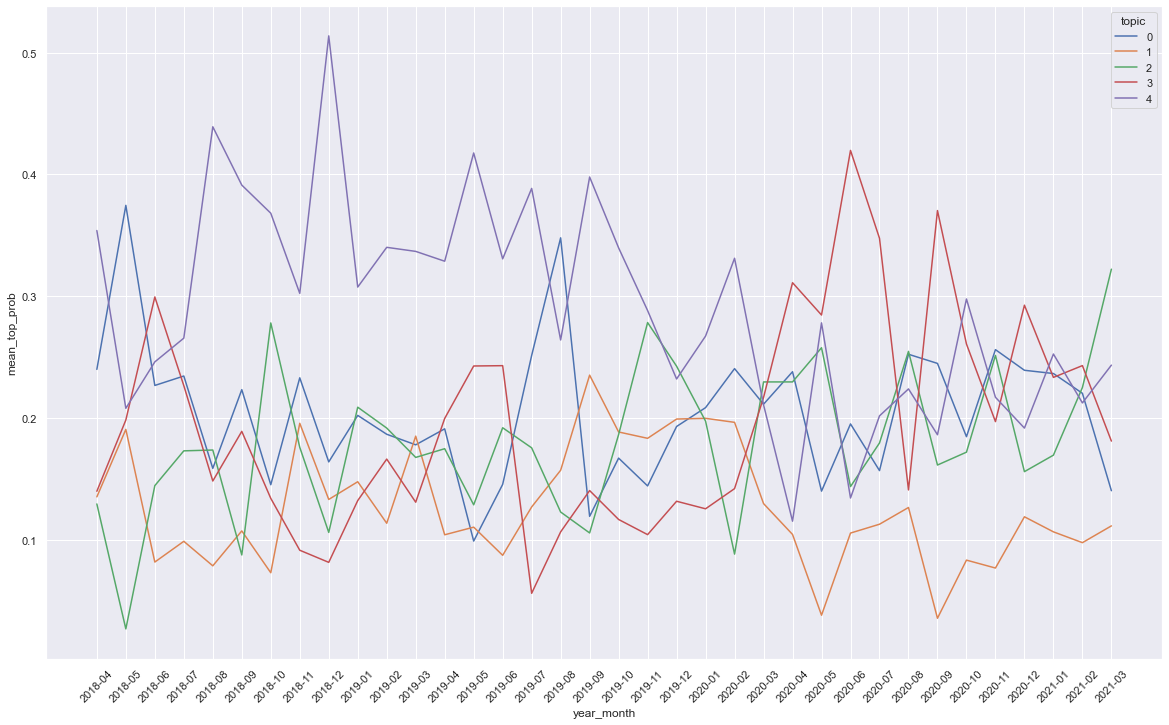

In [356]:
# Visualize topics over time

#viz_set = df_topictime.loc[df_topictime['topic'].isin([5, 13, 0]), :]
viz_set = df_topictime

sns.lineplot(data = viz_set, x = 'year_month', y = 'mean_top_prob', hue = 'topic')
plt.xticks(rotation = 45)
plt.show()

In [378]:
# Dominant topic

idx = df_topiclong.groupby(['url'])['topic_prob'].transform('max') == df_topiclong['topic_prob']

#df_topiclong.groupby(['url'])['topic_prob'].transform('max')
df_domtop = df_topiclong[idx]

df_domtop.head()

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda,topic,topic_prob,post_month,post_year,year_month
3,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(3, 0.90707326)",3,0.907073,12,2020,2020-12
9,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(4, 0.896404)",4,0.896404,12,2020,2020-12
10,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",2020-12-03,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","[positiv, flertal, parat, frigive, sidste, ind...","(0, 0.9024556)",0,0.902456,12,2020,2020-12
19,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",2020-12-03,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(4, 0.8635776)",4,0.863578,12,2020,2020-12
20,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",2020-12-02,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","(0, 0.8460573)",0,0.846057,12,2020,2020-12


In [379]:
# Topics over time

df_topictime_grouped = df_domtop.groupby(['year_month', 'topic'])
df_topictime = df_topictime_grouped['topic_prob'].mean().to_frame(name = 'mean_top_prob').reset_index() # Counting
df_topictime['topic'] = df_topictime['topic'].astype('category')

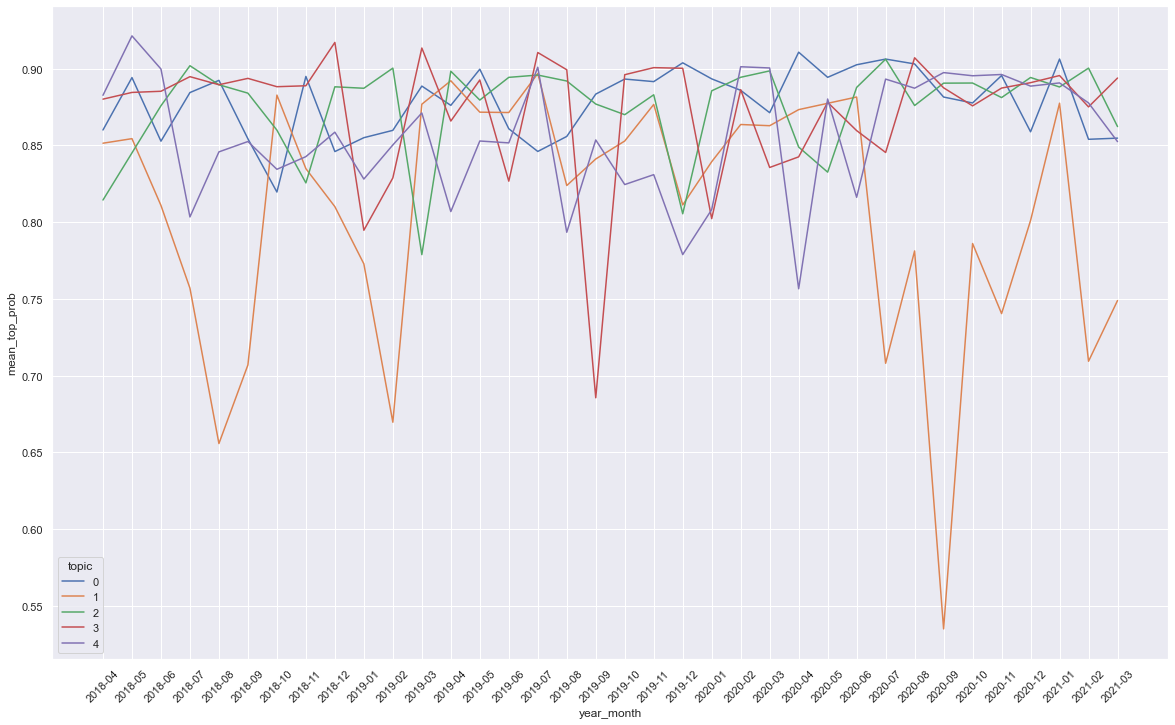

In [380]:
# Visualize topics over time

#viz_set = df_topictime.loc[df_topictime['topic'].isin([5, 13, 0]), :]
viz_set = df_topictime

sns.lineplot(data = viz_set, x = 'year_month', y = 'mean_top_prob', hue = 'topic')
plt.xticks(rotation = 45)
plt.show()

In [382]:
[word for word, prop in lda_model.show_topic(3, topn = 50)]

['restriktion',
 'erhverv',
 'hotel',
 'virksomhed',
 'hjælpepakke',
 'restaurant',
 'regering',
 'direktør',
 'omsætning',
 'politisk',
 'ramme',
 'mulighed',
 'kampagne',
 'mangen',
 'aftale',
 'juridisk',
 'dansk',
 'fortælle',
 'udenlandsk',
 'medarbejder',
 'måned',
 'spørgsmål',
 'periode',
 'oplevelseserhvervet',
 'svare',
 'komme',
 'holde',
 'kompensation',
 'horesta',
 'finde',
 'regel',
 'kommune',
 'overnatning',
 'yderlig',
 'procent',
 'samtidig',
 'gælde',
 'forlænge',
 'nedlukning',
 'dansker',
 'krise',
 'følge',
 'myndighed',
 'megen',
 'branche',
 'restauranterhvervet',
 'email',
 'sikre',
 'mulig',
 'række']